# Solving the Shallow Water Equations (2D + t) as an Inverse Problem

## Problem Statement

We consider the 2D shallow water equations (SWE) with the following form:

### Conservation of Mass:
$$
\frac{\partial h}{\partial t} + \frac{\partial (hV_x)}{\partial x} + \frac{\partial (hV_y)}{\partial y} = 0,
$$

### Momentum Equation in the x-direction:
$$
\frac{\partial V_x}{\partial t} + V_x \frac{\partial V_x}{\partial x} + V_y \frac{\partial V_x}{\partial y} + g \frac{\partial h}{\partial x} = 0,
$$

### Momentum Equation in the y-direction:
$$
\frac{\partial V_y}{\partial t} + V_x \frac{\partial V_y}{\partial x} + V_y \frac{\partial V_y}{\partial y} + g \frac{\partial h}{\partial y} = 0
$$

where:
- $h(x, y, t)$ is the water height,
- $V_x(x, y, t)$ and $V_y(x, y, t)$ are the velocity components in the x and y directions,
- $g$ is the gravitational constant.

## Inverse Problem

In this notebook, we aim to solve the shallow water equations using a Physics-Informed Neural Network (PINN). Unlike traditional forward problems, where the initial conditions (ICs) and boundary conditions (BCs) are known, we treat this as an inverse problem. Specifically, we assume that we do not have direct information about the ICs and BCs. Instead, we have access to a sparse set of observed data points generated from a numerical solver (RK4).

### Key Assumptions:

1. **Sparse Data Availability**: We only have observed data for 10% of the points in the domain.
2. **No Explicit ICs and BCs**: Instead of explicitly known ICs and BCs, we rely on the observed data to guide the solution.
3. **PDE Residuals**: The PINN is trained to minimize the residuals of the PDEs along with the loss from the observed data points.

## Methodology

### Data Generation
- We use the Runge-Kutta 4th Order (RK4) method to generate data points for the water height \(h\) and velocity components $V_x$, $V_y$ over time.
- A subset (10%) of these data points is used as the observed data.

### PINN Setup
- A neural network is defined to approximate the solution of the shallow water equations.
- The loss function combines the residuals of the PDEs and the difference between the PINN predictions and the observed data.

### Training
- The network is trained using the Adam optimizer.
- The total loss, including the PDE residuals and data loss, is minimized.

### Visualization
- The trained model's predictions are compared with the observed data and the RK4 solution.

By approaching the problem in this way, we leverage the physics-informed framework to enforce the underlying physical laws while fitting the sparse observed data. This allows us to solve the inverse problem and predict the solution accurately even with limited data availability.


### Data Generation via RK4

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, clear_output

# Define the RK4 solver for the shallow water equations
def rk4_step(f, y, t, dt, *args):
    k1 = f(y, t, *args)
    k2 = f(y + 0.5 * k1 * dt, t + 0.5 * dt, *args)
    k3 = f(y + 0.5 * k2 * dt, t + 0.5 * dt, *args)
    k4 = f(y + k3 * dt, t + dt, *args)
    return y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

def shallow_water_rhs(y, t, g):
    h, u, v = y
    h_x = np.gradient(h, axis=0)
    h_y = np.gradient(h, axis=1)
    u_x = np.gradient(u, axis=0)
    u_y = np.gradient(u, axis=1)
    v_x = np.gradient(v, axis=0)
    v_y = np.gradient(v, axis=1)
    h_t = - (h * u_x + h * v_y)
    u_t = - (u * u_x + v * u_y + g * h_x)
    v_t = - (u * v_x + v * v_y + g * h_y)
    return np.array([h_t, u_t, v_t])

# Initial conditions
def initial_conditions(x, y):
    h = np.exp(-((x - 0.5)**2 + (y - 0.5)**2) / (2 * 0.1**2))
    u = np.zeros_like(x)
    v = np.zeros_like(y)
    return h, u, v

# Generate data using RK4
def generate_data():
    num_points = 100
    x = np.linspace(0, 1, num_points)
    y = np.linspace(0, 1, num_points)
    X, Y = np.meshgrid(x, y, indexing='ij')
    t_max = 0.5
    dt = 0.01
    g = 9.81

    h, u, v = initial_conditions(X, Y)
    y = np.array([h, u, v])
    t = 0.0
    data = []

    while t < t_max:
        data.append((t, h.copy(), u.copy(), v.copy()))
        y = rk4_step(shallow_water_rhs, y, t, dt, g)
        h, u, v = y
        t += dt

    return data

# Generate data
data = generate_data()

# Select 10% of data points as observed data
def select_observed_data(data, fraction=0.1):
    num_data_points = len(data)
    num_observed_points = int(num_data_points * fraction)
    indices = np.random.choice(num_data_points, num_observed_points, replace=False)
    observed_data = [data[i] for i in indices]
    return observed_data

observed_data = select_observed_data(data)


## PINN structure

In [ ]:
# Define the PINN model
class SWE_PINN(nn.Module):
    def __init__(self, num_hidden_layers, num_neurons):
        super(SWE_PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, num_neurons),
            nn.Tanh(),
            *[nn.Sequential(nn.Linear(num_neurons, num_neurons), nn.Tanh()) for _ in range(num_hidden_layers - 1)],
            nn.Linear(num_neurons, 3)  # Output: h, u, v
        )

    def forward(self, x, y, t):
        xy_t = torch.cat([x, y, t], dim=1)
        return self.net(xy_t)


## Loss calculation function

In [ ]:
# Define the loss function for the inverse problem with PDE residuals
def compute_loss(model, x, y, t, h_real, u_real, v_real, g):
    # Predictions for all points
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)

    h, u, v = model(x, y, t).chunk(3, dim=1)

    # Calculate derivatives
    h_t = torch.autograd.grad(h, t, torch.ones_like(h), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]
    h_x = torch.autograd.grad(h, x, torch.ones_like(h), create_graph=True)[0]
    h_y = torch.autograd.grad(h, y, torch.ones_like(h), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True)[0]

    # PDE residuals
    continuity_residual = h_t + (h * u_x) + (h * v_y)
    momentum_x_residual = u_t + u * u_x + v * u_y + g * h_x
    momentum_y_residual = v_t + u * v_x + v * v_y + g * h_y

    loss_continuity = torch.mean(continuity_residual**2)
    loss_momentum_x = torch.mean(momentum_x_residual**2)
    loss_momentum_y = torch.mean(momentum_y_residual**2)

    # Data loss
    loss_h = torch.mean((h - h_real)**2)
    loss_u = torch.mean((u - u_real)**2)
    loss_v = torch.mean((v - v_real)**2)

    # Total loss
    total_loss = loss_continuity + loss_momentum_x + loss_momentum_y + loss_h + loss_u + loss_v
    return total_loss, loss_continuity, loss_momentum_x, loss_momentum_y, loss_h, loss_u, loss_v


## Data generation

In [ ]:
# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_hidden_layers = 10
num_neurons = 70
model = SWE_PINN(num_hidden_layers, num_neurons).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Prepare data for PINN training
X, Y = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100), indexing='ij')
x = torch.tensor(np.concatenate([X.flatten() for t, h, u, v in data]), dtype=torch.float32).reshape(-1, 1).to(device)
y = torch.tensor(np.concatenate([Y.flatten() for t, h, u, v in data]), dtype=torch.float32).reshape(-1, 1).to(device)
t = torch.tensor(np.concatenate([np.full_like(X.flatten(), fill_value=t) for t, h, u, v in data]), dtype=torch.float32).reshape(-1, 1).to(device)
h_real = torch.tensor(np.concatenate([h.flatten() for t, h, u, v in data]), dtype=torch.float32).reshape(-1, 1).to(device)
u_real = torch.tensor(np.concatenate([u.flatten() for t, h, u, v in data]), dtype=torch.float32).reshape(-1, 1).to(device)
v_real = torch.tensor(np.concatenate([v.flatten() for t, h, u, v in data]), dtype=torch.float32).reshape(-1, 1).to(device)

# Select observed data points
obs_x = torch.tensor(np.concatenate([X.flatten() for t, h, u, v in observed_data]), dtype=torch.float32).reshape(-1, 1).to(device)
obs_y = torch.tensor(np.concatenate([Y.flatten() for t, h, u, v in observed_data]), dtype=torch.float32).reshape(-1, 1).to(device)
obs_t = torch.tensor(np.concatenate([np.full_like(X.flatten(), fill_value=t) for t, h, u, v in observed_data]), dtype=torch.float32).reshape(-1, 1).to(device)
obs_h = torch.tensor(np.concatenate([h.flatten() for t, h, u, v in observed_data]), dtype=torch.float32).reshape(-1, 1).to(device)
obs_u = torch.tensor(np.concatenate([u.flatten() for t, h, u, v in observed_data]), dtype=torch.float32).reshape(-1, 1).to(device)
obs_v = torch.tensor(np.concatenate([v.flatten() for t, h, u, v in observed_data]), dtype=torch.float32).reshape(-1, 1).to(device)

# Training loop
epochs = 1000
g = 9.81
losses = {'total_loss': [], 'loss_continuity': [], 'loss_momentum_x': [], 'loss_momentum_y': [],
          'loss_h': [], 'loss_u': [], 'loss_v': []}

# Create a figure for live plotting
fig, ax = plt.subplots()
lines = {key: ax.plot([], [], label=key)[0] for key in losses}
ax.set_xlim(0, epochs)
ax.set_yscale('log')
ax.set_ylim(1e-9, 1)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

def update_plot(epoch):
    for key, line in lines.items():
        line.set_data(range(len(losses[key])), losses[key])
    ax.relim()
    ax.autoscale_view()
    clear_output(wait=True)
    display(fig)
    plt.pause(0.01)


## Training

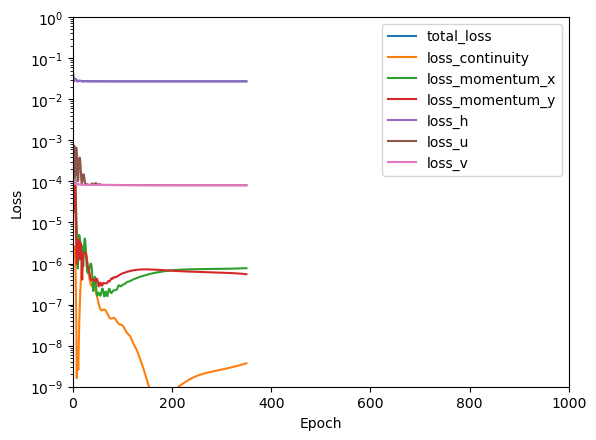

Training Model:  38%|███▊      | 381/1000 [01:35<02:25,  4.25it/s, Total Loss=0.0274, Continuity=0.0000, Momentum X=0.0000, Momentum Y=0.0000, Loss h=0.0272, Loss u=0.0001, Loss v=0.0001]

In [1]:

pbar = tqdm(range(epochs), desc="Training Model")
for epoch in pbar:
    optimizer.zero_grad()
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    
    # Compute loss
    total_loss, loss_continuity, loss_momentum_x, loss_momentum_y, loss_h, loss_u, loss_v = compute_loss(model, obs_x, obs_y, obs_t, obs_h, obs_u, obs_v, g)
    total_loss.backward()
    optimizer.step()

    # Update losses
    losses['total_loss'].append(total_loss.item())
    losses['loss_continuity'].append(loss_continuity.item())
    losses['loss_momentum_x'].append(loss_momentum_x.item())
    losses['loss_momentum_y'].append(loss_momentum_y.item())
    losses['loss_h'].append(loss_h.item())
    losses['loss_u'].append(loss_u.item())
    losses['loss_v'].append(loss_v.item())

    # Update tqdm
    pbar.set_postfix({
        'Total Loss': f'{total_loss.item():.4f}',
        'Continuity': f'{loss_continuity.item():.4f}',
        'Momentum X': f'{loss_momentum_x.item():.4f}',
        'Momentum Y': f'{loss_momentum_y.item():.4f}',
        'Loss h': f'{loss_h.item():.4f}',
        'Loss u': f'{loss_u.item():.4f}',
        'Loss v': f'{loss_v.item():.4f}'
    })

    # Update live plot
    if epoch % 50 == 0:
        update_plot(epoch)

plt.show()


### Visualization

In [ ]:
# Compute PINN predictions for the x-y plane at a specific time t=0.5
x_plot = torch.linspace(0, 1, 100).to(device)
y_plot = torch.linspace(0, 1, 100).to(device)
X_plot, Y_plot = torch.meshgrid(x_plot, y_plot, indexing='ij')
t_plot = torch.full_like(X_plot, 0.5).to(device)

X_plot_flat = X_plot.flatten().view(-1, 1)
Y_plot_flat = Y_plot.flatten().view(-1, 1)
t_plot_flat = t_plot.flatten().view(-1, 1)

with torch.no_grad():
    H_plot = model(X_plot_flat, Y_plot_flat, t_plot_flat)[:, 0].cpu().numpy().reshape(100, 100)

# Plotting
plt.figure(figsize=(8, 6))
plt.contourf(x_plot.cpu().numpy(), y_plot.cpu().numpy(), H_plot, levels=50, cmap='viridis')
plt.colorbar()
plt.title('PINN Solution for h at t=0.5')
plt.xlabel('x')
plt.ylabel('y')
plt.show()